### Introduction to PyTorch and Neural Networks
#### Charles Stewart
#### November 26, 2017

This is a brief tutorial introduction to PyTorch using a specific example of building
a neural network that learns to classify points as inside or outside a hyper sphere
of a given radius.

We'll start with the problem itself, working purely in NumPy in order to clarify
what we are trying to do.  After this, we'll introduce the basic notations of PyTorch, and proceed to two different neural network solutions.

Generated points in array of dimension (400, 2)
Binary labels are in a second array of dimension (400, 2)


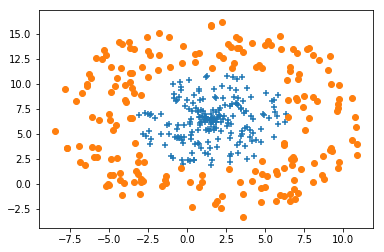

In [1]:
# -*- coding: utf-8 -*-
import numpy as np

def gen_from_sphere( n, center, r_min, r_max):
    '''
    Generate n points in random directions from a center that are at least
    r_min away and at most r_max away.  If r_min is 0 then the points are
    within a hyper sphere of radius r_max.  Otherwise, the points are within a
    spherical shell whose minimum radius is r_min and whose maximum radius
    is r_max.  Note that the points generated in this simple way are not
    uniformly distributed in Euclidean space, but that is not a major concern
    here.
    
    The dimensionality of the space is inferred from the dimension of the center
    point.  
    
    Return an array where each row is a data point.  I.e. the array in n X dim
    '''
    dim = center.size
    points = np.broadcast_to(center.reshape(1,dim),(n,dim)) 
    directions = 2*np.random.random((n,dim))-1
    directions /= np.linalg.norm(directions,axis=1).reshape((n,1))
    offsets = np.random.random(n) * (r_max-r_min) + r_min
    points = points + directions * offsets.reshape((n,1))
    return points


def gen_points_nested_spheres( n, center, r_min, r_max, debug=False):
    '''
    Generate n data points in hypersphere, half of which - the "inliers" --
    are within r_min of the center and half of which -- the "outliers" -- are
    between r_min and r_max.  Returned are the points in an n X d array
    (dim is the dimension of the center point) and a n X 2 binary array
    labeling whether the points are inliers (1,0) or outliers (0,1).
    
    If the debug flag is on, the array shape of the points and the labels
    are output.  In addition, if the dimension is 2 plot is generated.
    '''
    num_inliers = n//2
    num_outliers = n - num_inliers
    inlier_X = gen_from_sphere( num_inliers, center, 0, r_min)
    inlier_Y = np.broadcast_to( np.array([1.,0.]), (num_inliers,2))
    outlier_X = gen_from_sphere( num_outliers, center, r_min, r_max)
    outlier_Y = np.broadcast_to( np.array([0.,1.]), (num_outliers,2))
    X = np.concatenate( (inlier_X,outlier_X), axis=0)
    Y = np.concatenate( (inlier_Y,outlier_Y), axis=0)
    
    if debug:
        print('Generated points in array of dimension', X.shape)
        print('Binary labels are in a second array of dimension', Y.shape)
        
        if center.size == 2:
            from matplotlib import pyplot as plt
            plt.scatter( inlier_X[:,0], inlier_X[:,1], marker='+' )
            plt.scatter( outlier_X[:,0], outlier_X[:,1], marker='o' )
            plt.show()

    return X,Y

# Generate an example in 2d, just to see the point distribution
# The "real" data 
num_points = 400
center = np.array( [1.5, 6.4])
r_min, r_max = 5, 10
X,Y = gen_points_nested_spheres( num_points, center, r_min, r_max, debug=True)


### PyTorch

Now for PyTorch.  The starting point is http://pytorch.org/tutorials/ for tutorials and http://pytorch.org/docs/master/ for extensive documentation.  On the tutorials site, I found both the "60 Minute Blitz" and "Learning PyTorch with Examples" to be useful, but preferred the latter.  It starts with a simple neural network implemented in NumPy, then converts this to use of pytorch Tensors.  Next it introduces Variables and their most important property, automatic gradient calculation ("autograd").  At that point it has two subsections, one on defining new autograd functions and the second comparing to TensorFlow Static Graphs.  Neither of these is terribly important on first reading.  Instead, I'd suggest skipping ahead to the nn module.  I suggest going back to the 60 Minute Blitz for example of convolutional layes

We'll start here with a brief discussion of Tensors and Variables and then jump right into Neural Networks.

In [2]:
import torch
from torch.autograd import Variable

# The first important property of torch is the notion of a Tensor.  This is essentially
# the same as a NumPy array, but it has CUDA / GPU capabilities when a GPU is available.
# We can easily convert back and forth between Tensors and arrays without deep copying

# The following creates a 2d tensor with 6 rows and 3 columns, filled in with random
# values from a normal distribution of mean 0 and variance 1.
w = torch.randn(6, 3)
print('First tensor: w')
print(w)

First tensor: w

 0.7862  0.1672 -1.2225
 1.3326 -0.4643 -0.7408
-0.8263 -0.0365  0.2912
-0.6328 -0.4782 -1.4847
 0.5327  0.0460 -1.3296
-0.5171  1.6835 -0.8570
[torch.FloatTensor of size 6x3]



In [3]:
# Tensors can be sliced and this works without deep copying
x = w[2:4, 0:2]
print('Sliced verson of W is x:')
print(x)
x[0,1] = 20
print('We changed x[0,1] to', x[0,1], 'and now w[2,1] is also', w[2,1])

Sliced verson of W is x:

-0.8263 -0.0365
-0.6328 -0.4782
[torch.FloatTensor of size 2x2]

We changed x[0,1] to 20.0 and now w[2,1] is also 20.0


In [4]:
#  Create a row vector and then do component-wise multiplication
u = torch.randn( 3 )
print('3-component vector as a tensor:', u)
print('Component-wise multiplication, with broadcasting')
print(w*u)

3-component vector as a tensor: 
-0.7055
-0.8510
-0.7285
[torch.FloatTensor of size 3]

Component-wise multiplication, with broadcasting


RuntimeError: inconsistent tensor size at /Users/soumith/code/pytorch-builder/wheel/pytorch-src/torch/lib/TH/generic/THTensorMath.c:842

In [5]:
#  Now create a 3x1 tensor--- essentially a column vector --- and do
#  matrix multiplication
u = torch.randn( 3,1 )
print( torch.mm(w,u))


-1.9014
-1.3762
-5.3939
-1.3635
-1.8766
-1.3173
[torch.FloatTensor of size 6x1]



In [6]:
#  Many of the methods you'd expect for NumPy arrays exist for PyTorch tensors.  See
#  extensive documentation at http://pytorch.org/docs/master/torch.html#tensors

# We can go back and forth between NumPy arrays and PyTorch tensors
# through shallow copies
a = u.numpy()
print('a is the numpy version of u:\n', a)
b = torch.from_numpy(a)
c = torch.Tensor(b)
print('b and c are back to pytorch:', b)
a[0,0] = 5
print('We changed a[0,0] and this changes b and c as well:')
print('b[0,0] =', b[0,0], 'and c[0,0] =', c[0,0])

a is the numpy version of u:
 [[-0.46416229]
 [-0.30656284]
 [ 1.21491838]]
b and c are back to pytorch: 
-0.4642
-0.3066
 1.2149
[torch.FloatTensor of size 3x1]

We changed a[0,0] and this changes b and c as well:
b[0,0] = 5.0 and c[0,0] = 5.0


In [7]:
# So why create a separate class for tensors when they seem to have
# the same attributes as as NumPy arrays?  There are two answers.

# First, tensors are designed to work with CUDA when a GPU is available,
# but this is transparent to the rest of the code:
if torch.cuda.is_available():
    w = w.cuda()
    b = b.cuda()

c = torch.mm(w,b)
print('Tensor c is', c)  # Proceeds whether on CPU or GPU

Tensor c is 
 2.3944
 5.9052
-9.9090
-4.8210
 1.0339
-4.1426
[torch.FloatTensor of size 6x1]



### PyTorch Variables
The second reason for PyTorch tensors is that they are designed to work with our second
major PyTorch construct:  Variables.  A Variable has three major attributes:
1. data --- A PyTorch tensor.   
2. grad --- The gradient tensor of the variable with respect to the final cost function it is used in
3. creator - The link to the function the Variable is created from.  More on this below

In [8]:
print('Reminding ourselves:  w=', w)

Reminding ourselves:  w= 
  0.7862   0.1672  -1.2225
  1.3326  -0.4643  -0.7408
 -0.8263  20.0000   0.2912
 -0.6328  -0.4782  -1.4847
  0.5327   0.0460  -1.3296
 -0.5171   1.6835  -0.8570
[torch.FloatTensor of size 6x3]



In [9]:
# Now create a variable from w, telling the constructor that we want
# to be able to compute gradients on this variable.
wv = Variable(w, requires_grad=True)
print("wv=", wv)
print('wv.data =', wv.data)
print('Slicing works on variables:', wv[2:4,1:3])

wv= Variable containing:
  0.7862   0.1672  -1.2225
  1.3326  -0.4643  -0.7408
 -0.8263  20.0000   0.2912
 -0.6328  -0.4782  -1.4847
  0.5327   0.0460  -1.3296
 -0.5171   1.6835  -0.8570
[torch.FloatTensor of size 6x3]

wv.data = 
  0.7862   0.1672  -1.2225
  1.3326  -0.4643  -0.7408
 -0.8263  20.0000   0.2912
 -0.6328  -0.4782  -1.4847
  0.5327   0.0460  -1.3296
 -0.5171   1.6835  -0.8570
[torch.FloatTensor of size 6x3]

Slicing works on variables: Variable containing:
 20.0000   0.2912
 -0.4782  -1.4847
[torch.FloatTensor of size 2x2]



In [10]:
#  Next create a simple cost function
cost = torch.mean( wv*wv )  # Cost is the square magnitude of the elments of the matrix
print('cost is', cost)

cost is Variable containing:
 23.0095
[torch.FloatTensor of size 1]



#### Now comes the gradient!
By calling the method *backward*, we backpropagate the gradient through the computation used to create the cost function value.  In this simple case, we are computing the gradient with respect to the terms of our our small $m \times n$ ($ 6 \times 3$) 2d tensor.  The result should be another 2d tensor whose values are $\frac{2}{m n} w[i,j]$. When we ask for the values of the gradient we get exactly what we predicted.  For example, the 2,2 entry in the gradient, corresponding to the value 20 in wv, is $2/18\times 20$ as the following shows:

In [11]:
cost.backward()
print('wv.grad=', wv.grad)

wv.grad= Variable containing:
 0.0874  0.0186 -0.1358
 0.1481 -0.0516 -0.0823
-0.0918  2.2222  0.0324
-0.0703 -0.0531 -0.1650
 0.0592  0.0051 -0.1477
-0.0575  0.1871 -0.0952
[torch.FloatTensor of size 6x3]



###  Creator / grad_fn

In order to briefly discuss the creator function, we take this further in the following example by combining several variables, similar to the computation in a fully connected layer of a neural network.  This combination can be thought of as a simple graph where the root is the cost function, each node in the middle is the result of an intermediate function, and our leaves are the initial variables we are interested in. The nodes have grad_fn that point back to the previous nodes (or leaves) combined to create them.  Leaves have no grad_fn.

The print statements from the following only show these grad_fn values, but if you wish you can add print statements to calculate the gradients.


In [12]:
av = Variable(torch.randn( 3, 1),requires_grad = True)
bv = Variable(torch.randn( 6, 1),requires_grad = True )
mult = torch.mm(wv,av) + bv
cost = torch.mean(mult)
cost.backward()
print('cost.grad_fn:', cost.grad_fn)
print('mult.grad_fn:', mult.grad_fn)
print('av.grad_fn:', av.grad_fn)
print('bv.grad_fn:', bv.grad_fn)
print('wv.grad_fn:', wv.grad_fn)
print('av.grad:', av.grad)
print('mult.grad:', mult.grad)

AttributeError: grad_fn

### Neural Networks in PyTorch
Using Variables and the build up of functions between them, we can create neural network by hand.  Doing so is a good exercise in understanding the basics of PyTorch and if you are going to do significant work in neural networks I recommend that you do so.  For our purposes, however, we are going to switch gears to the higher-level capabilities in PyTorch for defining an using neural networks from standard components.

Before getting started, we return to our hypersphere classification problem, and generate the data we will actually use to train, validata and test our neural network.

In [13]:
#  The points, the center location and the dimensions of the 
#  internal hypersphere and the external disk.
point_dim = 4
center = 10*np.random.randn(point_dim)
r_min, r_max = 4, 8

def generate_and_convert( n, center, r_min, r_max, debug=True, name=''):
    '''
    Generate the data for the interior and exterior points and convert
    to PyTorch variables.
    '''
    X, Y = gen_points_nested_spheres( n, center, r_min, r_max, debug)
    X, Y = Variable(torch.Tensor(X)), Variable(torch.Tensor(Y))
    if debug:
        print('generate_and_convert for', name, ' X size ', X.size(), ', Y size', Y.size())
    return X, Y

n_train, n_valid, n_test = 640, 128, 128
X_train, Y_train = generate_and_convert( n_train, center, r_min, r_max, debug=True, name='Train')
X_valid, Y_valid = generate_and_convert( n_valid, center, r_min, r_max, debug=True, name='Valid')
X_test, Y_test = generate_and_convert( n_test, center, r_min, r_max, debug=True, name='Valid')



Generated points in array of dimension (640, 4)
Binary labels are in a second array of dimension (640, 2)
generate_and_convert for Train  X size  torch.Size([640, 4]) , Y size torch.Size([640, 2])
Generated points in array of dimension (128, 4)
Binary labels are in a second array of dimension (128, 2)
generate_and_convert for Valid  X size  torch.Size([128, 4]) , Y size torch.Size([128, 2])
Generated points in array of dimension (128, 4)
Binary labels are in a second array of dimension (128, 2)
generate_and_convert for Valid  X size  torch.Size([128, 4]) , Y size torch.Size([128, 2])


In [24]:
Y_train.data.type

<bound method _type of 
    1     0
    1     0
    1     0
     ⋮      
    0     1
    0     1
    0     1
[torch.FloatTensor of size 640x2]
>

### Defining a simple fully connected network

The cell below shows the definition of a neural network with two hidden layers of 15 nodes each.
It is defined as a subclass of the nn.Module class, so the first step in the initializer is to call the initializer for the base class.
The initializer for our new class creates the layers --- each fully-connected --- but does not hook them together.  This is done in the forward function.
You will also notice that there is no definition of the backward function, even though it is used.
This function is created in the base class based on the result of the forward function.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

N0 = point_dim
N1 = 15
N2 = 15
Nout = 2  

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Create three fully connected layers, two of which are hidden and the third is
        # the output layer.  In each case, the first argument o Linear is the number
        # of input values from the previous layer, and the second argument is the number
        # of nodes in this layer.  The call to the Linear initializer creates a PyTorch
        # functional that in turn adds a weight matrix and a bias vector to the list of
        # (learnable) parameters stored with each Net object.  These weight matrices
        # and bias vectors are implicitly initialized using a normal distribution
        # with mean 0 and variance 1
        self.fc1 = nn.Linear( N0, N1, bias=True)
        self.fc2 = nn.Linear( N1, N2, bias=True)
        self.fc3 = nn.Linear( N2, Nout, bias=True)

    def forward(self, x):
        #  The forward method takes an input Variable and creates a chain of Variables
        #  from the layers of the network defined in the initializer. The F.relu is
        #  a functional implementing the Rectified Linear activation function.
        #  Notice that the output layer does not include the activation function.
        #  As we will see, that is combined into the criterion for the loss function.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#  Create an instance of this network.
net = Net()

#  Define the Mean Squared error loss function as the criterion for this network's training
criterion = nn.MSELoss()

#  Print a summary of the network.  Notice that this only shows the layers
print(net)

#  Print a s
params = list(net.parameters())
print(params[0].size()) # The parameter holding the layer 1 weight matrix
print(params[1].size()) # ... the layer 1 bias vector
print(params[2].size()) # ... the layer 2 weight matrix
print(params[3].size()) # ... the layer 3 bias vector
print(params[4].size()) # ... the layer 4 weight vector
print(params[5].size()) # ... the layer 5 bias vector

Net (
  (fc1): Linear (4 -> 15)
  (fc2): Linear (15 -> 15)
  (fc3): Linear (15 -> 2)
)
torch.Size([15, 4])
torch.Size([15])
torch.Size([15, 15])
torch.Size([15])
torch.Size([2, 15])
torch.Size([2])


In [15]:
point_dim

4

####  Training the network

Now we can write our own training function using a form of stochastic gradient descent. 

In [25]:
#  Set parameters to control the process
epochs = 1000
batch_size = 16
n_batches = int(np.ceil(n_train / batch_size))
learning_rate = 1e-4

#  Compute an initial loss using all of the validation data.
#
#  A couple of notes are important here:
#  (1) X_valid contains all of the validation input, with each validation
#      data instance being a row of X_valid
#  (2) Therefore, pred_Y_valid is a Variable containing the output layer
#      activations for each of the validation inputs.
#  (3) This is accomplished through the function call net(X_valid), which in
#      turn calls the forward method under the hood to figure out the flow of
#      the data and activations in the network.
pred_Y_valid = net(X_valid)
valid_loss = criterion(pred_Y_valid, Y_valid)
print("Initial loss: %.5f" %valid_loss.data[0])

for ep in range(epochs):
    #  Create a random permutation of the indices of the row vectors.
    indices = torch.randperm(n_train)
    
    #  Run through each mini-batch
    for b in range(n_batches):
        #  Use slicing (of the pytorch Variable) to extract the
        #  indices and then the data instances for the next mini-batch
        batch_indices = indices[b*batch_size:(b+1)*batch_size]
        batch_X = X_train[batch_indices]
        batch_Y = Y_train[batch_indices]
        
        #  Run the network on each data instance in the minibatch
        #  and then compute the object function value
        pred_Y = net(batch_X)
        loss = criterion(pred_Y, batch_Y)
        
        #  Back-propagate the gradient through the network using the
        #  implicitly defined backward function, but zero out the
        #  gradient first.
        net.zero_grad()
        loss.backward()

        #  Complete the mini-batch by actually updating the parameters.
        for param in net.parameters():
            param.data -= learning_rate * param.grad.data
            
    #  Print validation loss every 10 epochs
    if ep != 0 and ep%10==0:
        pred_Y_valid = net(X_valid)
        valid_loss = criterion(pred_Y_valid, Y_valid)
        print("Epoch %d loss: %.5f" %(ep, valid_loss.data[0]))

#  Compute and print the final training and test loss
#  function values
pred_Y_train = net(X_train)
loss = criterion(pred_Y_train, Y_train)
print('Final training loss is %.5f' %loss.data[0])

pred_Y_test = net(X_test)
test_loss = criterion(pred_Y_test, Y_test)
print("Final test loss: %.5f" %test_loss.data[0])

Initial loss: 1.53148
Epoch 10 loss: 0.33305
Epoch 20 loss: 0.31003
Epoch 30 loss: 0.30273
Epoch 40 loss: 0.29710
Epoch 50 loss: 0.29145
Epoch 60 loss: 0.28595
Epoch 70 loss: 0.28084
Epoch 80 loss: 0.27589
Epoch 90 loss: 0.27102
Epoch 100 loss: 0.26626
Epoch 110 loss: 0.26208
Epoch 120 loss: 0.25782
Epoch 130 loss: 0.25390
Epoch 140 loss: 0.25048
Epoch 150 loss: 0.24741
Epoch 160 loss: 0.24454
Epoch 170 loss: 0.24192
Epoch 180 loss: 0.23956
Epoch 190 loss: 0.23749
Epoch 200 loss: 0.23556
Epoch 210 loss: 0.23376
Epoch 220 loss: 0.23200
Epoch 230 loss: 0.23024
Epoch 240 loss: 0.22856
Epoch 250 loss: 0.22694
Epoch 260 loss: 0.22534
Epoch 270 loss: 0.22382
Epoch 280 loss: 0.22234
Epoch 290 loss: 0.22091
Epoch 300 loss: 0.21955
Epoch 310 loss: 0.21827
Epoch 320 loss: 0.21701
Epoch 330 loss: 0.21575
Epoch 340 loss: 0.21449
Epoch 350 loss: 0.21328
Epoch 360 loss: 0.21213
Epoch 370 loss: 0.21094
Epoch 380 loss: 0.20976
Epoch 390 loss: 0.20860
Epoch 400 loss: 0.20744
Epoch 410 loss: 0.20628
Epo

In [27]:
pred_Y_test

Variable containing:
 0.7766  0.1987
 0.7134  0.2997
 0.6512  0.2563
 0.6162  0.3493
 0.6143  0.2970
 0.6689  0.3867
 0.6215  0.3720
 0.6450  0.2862
 0.8940  0.2054
 0.6492  0.4457
 0.7376  0.2561
 0.7719  0.2031
 0.6478  0.2746
 0.7372  0.3270
 0.6153  0.3036
 0.5786  0.4029
 0.6850  0.3054
 0.7660  0.1833
 0.7749  0.1832
 0.6947  0.3138
 0.6902  0.2499
 0.5361  0.3746
 0.6690  0.2925
 0.6197  0.2148
 0.6561  0.2834
 0.7770  0.1954
 0.4998  0.4427
 0.5647  0.3587
 0.6359  0.2791
 0.7594  0.4087
 0.4166  0.4061
 0.7818  0.1952
 0.6467  0.3003
 0.7080  0.2841
 0.7705  0.2172
 0.5966  0.3981
 0.7157  0.2352
 0.7778  0.2050
 0.4359  0.5342
 0.7566  0.2477
 0.7169  0.2482
 0.3728  0.4921
 0.5122  0.3248
 0.7099  0.2612
 0.7023  0.2279
 0.7929  0.2581
 0.7797  0.1804
 0.7591  0.2181
 0.7541  0.2219
 0.6737  0.3485
 0.3894  0.5345
 0.7755  0.1977
 0.7926  0.1911
 0.7892  0.2347
 0.7408  0.2636
 0.7163  0.4394
 0.7729  0.2022
 0.7331  0.2900
 0.6929  0.3471
 0.7754  0.1966
 0.6954  0.2774
 0.

### Classification Success Rate

The loss function value does not indicate the actual success rate.  In fact the MSE loss can in theory be arbitrarily bad and we could still have perfect classification.  By increasing the size of the training data and the number of epochs we can obtain better and better classification rates.

In [26]:
def success_rate(pred_Y, Y):
    '''
    Calculate and return the success rate from the predicted output Y and the
    expected output.  There are several issues to deal with.  First, the pred_Y
    is non-binary, so the classification decision requires finding which column
    index in each row of the prediction has the maximum value.  This is achieved
    by using the torch.max() method, which returns both the maximum value and the
    index of the maximum value; we want the latter.  We do this along the column,
    which we indicate with the parameter 1.  Second, the once we have a 1-d vector
    giving the index of the maximum for each of the predicted and target, we just
    need to compare and count to get the number that are different.  We could do
    using the Variable objects themselve, but it is easier syntactically to do this
    using the .data Tensors for obscure PyTorch reasons.
    '''
    _,pred_Y_index = torch.max(pred_Y, 1)
    _,Y_index = torch.max(Y,1)
    num_equal = torch.sum(pred_Y_index.data == Y_index.data)
    num_different = torch.sum(pred_Y_index.data != Y_index.data)
    rate = num_equal / float(num_equal + num_different)
    return rate

print('Training success rate:', success_rate(pred_Y_train, Y_train))
print('Test success rate:', success_rate(pred_Y_test, Y_test))

Training success rate: 0.8109375
Test success rate: 0.8515625


### Using Cross Entropy, SoftMax and SGD

As a final step in our initial learning of PyTorch, we'll examine use of the Cross-entropy loss function along with the softmax.  Then we'll examine use of built-in optimizers, in particular stochastic gradient descent (SGD).  Normally we think of SGD as having mini-batches and permutations associated with it, but that must be done explicitly here.  PyTorch does provide tools to help us, but this tutorial does not dig into them.

Unfortunately, SGD requires the target outputs to be categorical indices as rather than binary vectors.  In addition, these must be tensors of longs rather than tensors of doubles.   We could go back and change the code at the very beginning to make both of these corrections, but instead we use properties of PyTorch to make the changes here.

In [25]:
def convert_to_categories(Y):
    _, categories = torch.max(Y.data, 1)
    categories = torch.Tensor.long(categories)
    return Variable(categories)

Y_test_c = convert_to_categories(Y_test)
Y_train_c = convert_to_categories(Y_train)
Y_valid_c = convert_to_categories(Y_valid)


In [27]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-4)

pred_Y_valid = net(X_valid)
valid_loss = criterion(pred_Y_valid, Y_valid_c)
print('Initial validation loss: %.5f' %valid_loss.data[0])

num_epochs = 3000
for ep in range(num_epochs):
    #  Create a random permutation of the indices of the row vectors.
    indices = torch.randperm(n_train)
    
    #  Run through each mini-batch
    for b in range(n_batches):
        #  Use slicing (of the pytorch Variable) to extract the
        #  indices and then the data instances for the next mini-batch
        batch_indices = indices[b*batch_size:(b+1)*batch_size]
        batch_X = X_train[batch_indices]
        batch_Y = Y_train_c[batch_indices]
        
        #  Run the network on each data instance in the minibatch
        #  and then compute the object function value
        pred_Y = net(batch_X)
        loss = criterion(pred_Y, batch_Y)
        
        #  Back-propagate the gradient through the network using the
        #  implicitly defined backward function, but zero out the
        #  gradient first.  The step is made here by the optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    pred_Y = net(X_train)
    loss = criterion(pred_Y, Y_train_c)
    if ep !=0 and ep%10==0:
        pred_Y_valid = net(X_valid)
        valid_loss = criterion(pred_Y_valid, Y_valid_c)
        print("Epoch %d loss: %.5f" %(ep, valid_loss.data[0]))

pred_Y_train = net(X_train)
pred_Y_test = net(X_test)
print('Training success rate:', success_rate(pred_Y_train, Y_train))
print('Test success rate:', success_rate(pred_Y_test, Y_test))

Initial validation loss: 0.72988
Epoch 10 loss: 0.71921
Epoch 20 loss: 0.71302
Epoch 30 loss: 0.70591
Epoch 40 loss: 0.69471
Epoch 50 loss: 0.68894
Epoch 60 loss: 0.68712
Epoch 70 loss: 0.68560
Epoch 80 loss: 0.68430
Epoch 90 loss: 0.68315
Epoch 100 loss: 0.68209
Epoch 110 loss: 0.68107
Epoch 120 loss: 0.68013
Epoch 130 loss: 0.67928
Epoch 140 loss: 0.67853
Epoch 150 loss: 0.67779
Epoch 160 loss: 0.67709
Epoch 170 loss: 0.67641
Epoch 180 loss: 0.67579
Epoch 190 loss: 0.67515
Epoch 200 loss: 0.67447
Epoch 210 loss: 0.67382
Epoch 220 loss: 0.67316
Epoch 230 loss: 0.67252
Epoch 240 loss: 0.67181
Epoch 250 loss: 0.67116
Epoch 260 loss: 0.67050
Epoch 270 loss: 0.66982
Epoch 280 loss: 0.66904
Epoch 290 loss: 0.66836
Epoch 300 loss: 0.66761
Epoch 310 loss: 0.66695
Epoch 320 loss: 0.66622
Epoch 330 loss: 0.66545
Epoch 340 loss: 0.66467
Epoch 350 loss: 0.66394
Epoch 360 loss: 0.66323
Epoch 370 loss: 0.66253
Epoch 380 loss: 0.66165
Epoch 390 loss: 0.66097
Epoch 400 loss: 0.66008
Epoch 410 loss: 

### Summary

These results are by no means perfect and can be easily improved.  However, our emphasis has been on the basics.  I strongly recommend studying these examples and playing with similar code on your own.  Then, just jump into the HW 6 assignment.  You really can write the solutions with relatively little code.  You are also welcome to use as much of the code I've provided here as you wish.  The only thing I have not covered that you need is the implementation of convolutional networks, but you can find examples that will help you get started there.